In [158]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%matplotlib inline
plt.rcParams.update({'font.size': 12})

In [37]:
alldata_df = pd.read_csv('all_stocks_5yr.csv')
test_df = alldata_df[alldata_df['date'] > '2017-02-08']
alldata_df = alldata_df[alldata_df['date'] < '2017-02-08']
alldata_df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [38]:
def relative_strength_index(stock, n = 14):
    
    difference = stock['close'].diff()
    up, down = difference.copy(), difference.copy()
    up[up < 0] = 0
    down[down > 0] = 0
    rs = up.rolling(n).mean() / down.abs().rolling(n).mean()
    rsi = 100.0 - (100.0 / (1.0 + rs))
    
    return rsi

In [39]:
def average_directional_movement_index(stock, n=14, n_ADX=14):
    i = 0
    UpI = []
    DoI = []
    while i + 1 <= stock.index[-1]:
        UpMove = stock.loc[i + 1, 'high'] - stock.loc[i, 'high']
        DoMove = stock.loc[i, 'low'] - stock.loc[i + 1, 'low']
        if UpMove > DoMove and UpMove > 0:
            UpD = UpMove
        else:
            UpD = 0
        UpI.append(UpD)
        if DoMove > UpMove and DoMove > 0:
            DoD = DoMove
        else:
            DoD = 0
        DoI.append(DoD)
        i = i + 1
    i = 0
    TR_l = [0]
    while i < stock.index[-1]:
        TR = max(stock.loc[i + 1, 'high'], stock.loc[i, 'close']) - min(stock.loc[i + 1, 'low'], stock.loc[i, 'close'])
        TR_l.append(TR)
        i = i + 1
    TR_s = pd.Series(TR_l)
    ATR = pd.Series(TR_s.ewm(span=n, min_periods=n).mean())
    UpI = pd.Series(UpI)
    DoI = pd.Series(DoI)
    PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean() / ATR)
    NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean() / ATR)
    ADX = pd.Series((abs(PosDI - NegDI) / (PosDI + NegDI)).ewm(span=n_ADX).mean())
    ADX = 100*ADX
    
    return ADX

In [40]:
def bollinger_bands(stock, n=14):
    
    MA = stock['close'].rolling(n).mean()
    MSD = stock['close'].rolling(n).std()
    bandwidth = 4 * MSD / MA * 100

    return bandwidth

In [262]:
def get_stock_indicators(stock):
    
    stock = stock.reset_index().drop(['index','Name'], axis = 1)

    #stock['dailyrange'] = ((stock['high'] - stock['low'] )/ stock['low'])*100

    #stock['dailychange'] = stock['close'].pct_change()

    #stock['sma10'] = stock.loc[:,'close'].rolling(window = 14).mean()

    stock['ema10'] = stock['close'].ewm(span = 14, adjust = False).mean()
    
    #stock['rsi'] = relative_strength_index(stock,14)
    
    #stock['adx'] = average_directional_movement_index(stock,14,14)
    
    #stock['bollingerbw'] = bollinger_bands(stock,14)

    return stock

In [42]:
def principal_components(stock, ticker = 'stockname_in_parameter'):
    
    stockvalues = stock.iloc[:,4:].dropna().values

    scaler = StandardScaler()

    stock_for_PCA = scaler.fit_transform(stockvalues)
      
    stock_pca = PCA(svd_solver = 'full').fit(stock_for_PCA)

    stock_pc = PCA(svd_solver = 'full', n_components = 1).fit_transform(stock_for_PCA)
    
    print('% Variance Explained for '+ ticker + ' = {}'.format(round(stock_pca.explained_variance_ratio_[0],2)))
    
    return stock_pc.reshape(len(stock_pc))

In [43]:
def principal_components_with_fitter(stock, fitter):
   
    '''
    Fits a given stock to the PCs of another stock to see similarity.
    Returns the transformed stock wrt the PC1 of the fitter stock.
    
    '''
    
    stockvalues = stock.iloc[:,4:].dropna().values

    scaler = StandardScaler()

    stock_for_PCA = scaler.fit_transform(stockvalues)
    
    stock_pc = fitter.transform(stock_for_PCA)[:,0]
    
    return stock_pc.reshape(len(stock_pc))

In [44]:
def min_sum_row(mat):  
    
    idx = -1000  
    minSum = 1000 

    for i in range(0, len(mat[0])):  
        summation = 0
        
        for j in range(0, len(mat)):  
            summation += mat[j][i]  
            
        if (summation < minSum): 
            minSum = summation  
            idx = i  
    return idx, minSum

In [112]:
def correlation_minimized_selection_algorithm(selected_stocks, n=5 , first_stock = 'FB'):
    
    correlations = []
    diverse_stocks = [first_stock]
    
    for i in range(n-1):
        if i==0:
            stock = selected_stocks[selected_stocks['Name'] == first_stock]
            current_stock = first_stock
        else:
            stock = selected_stocks[selected_stocks['Name'] == next_stock]
            current_stock = next_stock
        
        stock = get_stock_indicators(stock)
        stock_pc1 = principal_components(stock, current_stock)
        scaler = StandardScaler()
        stock_for_pca = scaler.fit_transform(stock.iloc[:,4:].dropna().values)


        transformed_stocks = pd.DataFrame(index = range(len(stock_pc1)), columns = [current_stock])
        transformed_stocks[current_stock] = stock_pc1

        tickers = selected_stocks['Name'].unique().tolist()

        fitter = PCA(svd_solver = 'full').fit(stock_for_pca)

        for ticker in tickers:
            stock = selected_stocks[selected_stocks['Name'] == ticker]

            stock = get_stock_indicators(stock)

            stock_pc = principal_components_with_fitter(stock, fitter)

            if len(stock_pc) != len(transformed_stocks):
                continue
            transformed_stocks[ticker] = stock_pc
        
        correlations.append(transformed_stocks.corr()[current_stock].sort_index().tolist())
        min_index, min_sum = min_sum_row(correlations)
        print('Sum of the correlations is {}'.format(round(min_sum,2)))
        correlations[0][min_index] = 100.0
        next_stock = transformed_stocks.corr()[current_stock].index[min_index]
        if next_stock in diverse_stocks:
            print('Not adding ' + next_stock + ' again')
            continue
        diverse_stocks.append(next_stock)
        print('Next Most Diverse Stock is '+next_stock)
        
    return diverse_stocks, correlations

In [218]:
def correlation_maximized_selection_algorithm(selected_stocks, n=5 , first_stock = 'FB'):
    
    correlations = []
    diverse_stocks = [first_stock]
    
    for i in range(n-1):
        if i==0:
            stock = selected_stocks[selected_stocks['Name'] == first_stock]
            current_stock = first_stock
        else:
            stock = selected_stocks[selected_stocks['Name'] == next_stock]
            current_stock = next_stock
        
        stock = get_stock_indicators(stock)
        stock_pc1 = principal_components(stock, current_stock)
        scaler = StandardScaler()
        stock_for_pca = scaler.fit_transform(stock.iloc[:,4:].dropna().values)


        transformed_stocks = pd.DataFrame(index = range(len(stock_pc1)), columns = [current_stock])
        transformed_stocks[current_stock] = stock_pc1

        tickers = selected_stocks['Name'].unique().tolist()

        fitter = PCA(svd_solver = 'full').fit(stock_for_pca)

        for ticker in tickers:
            stock = selected_stocks[selected_stocks['Name'] == ticker]

            stock = get_stock_indicators(stock)

            stock_pc = principal_components_with_fitter(stock, fitter)

            if len(stock_pc) != len(transformed_stocks):
                continue
            transformed_stocks[ticker] = stock_pc
        
        correlations.append(transformed_stocks.corr()[current_stock].sort_index().tolist())
        max_index, max_sum = max_sum_row(correlations)
        print('Sum of the correlations is {}'.format(round(max_sum,2)))
        correlations[0][max_index] = -100.0
        next_stock = transformed_stocks.corr()[current_stock].index[max_index]
        if next_stock in diverse_stocks:
            print('Not adding ' + next_stock + ' again')
            continue
        diverse_stocks.append(next_stock)
        print('Next Most Similar Stock is '+next_stock)
        
    return diverse_stocks, correlations

In [561]:
def max_sum_row(mat):  
    
    idx = -1000  
    maxSum = -1000

    for i in range(0, len(mat[0])):  
        summation = 0
        
        for j in range(0, len(mat)):  
            summation += mat[j][i]  
            
        if (summation > maxSum): 
            maxSum = summation  
            idx = i  
    return idx, maxSum

In [559]:
def correlation_maximized_selection_algorithm(selected_stocks, n=5 , first_stock = 'FB'):
    
    correlations = []
    diverse_stocks = [first_stock]
    
    for i in range(n-1):
        if i==0:
            stock = selected_stocks[selected_stocks['Name'] == first_stock]
            current_stock = first_stock
        else:
            stock = selected_stocks[selected_stocks['Name'] == next_stock]
            current_stock = next_stock
        
        stock = get_stock_indicators(stock)
        stock_pc1 = principal_components(stock, current_stock)
        scaler = StandardScaler()
        stock_for_pca = scaler.fit_transform(stock.iloc[:,4:].dropna().values)


        transformed_stocks = pd.DataFrame(index = range(len(stock_pc1)), columns = [current_stock])
        transformed_stocks[current_stock] = stock_pc1

        tickers = selected_stocks['Name'].unique().tolist()

        fitter = PCA(svd_solver = 'full').fit(stock_for_pca)

        for ticker in tickers:
            stock = selected_stocks[selected_stocks['Name'] == ticker]

            stock = get_stock_indicators(stock)

            stock_pc = principal_components_with_fitter(stock, fitter)

            if len(stock_pc) != len(transformed_stocks):
                continue
            transformed_stocks[ticker] = stock_pc
        
        correlations.append(transformed_stocks.corr()[current_stock].sort_index().tolist())
        max_index, max_sum = max_sum_row(correlations)
        print('Sum of the correlations is {}'.format(round(max_sum,2)))
        correlations[0][max_index] = -100.0
        next_stock = transformed_stocks.corr()[current_stock].index[max_index]
        if next_stock in diverse_stocks:
            print('Not adding ' + next_stock + ' again')
            continue
        diverse_stocks.append(next_stock)
        print('Next Most Similar Stock is '+next_stock)
        
    return diverse_stocks, correlationsdef max_sum_row(mat):  
    
    idx = -1000  
    maxSum = -1000# Random Tries Follow! 

    for i in range(0, len(mat[0])):  
        summation = 0
        
        for j in range(0, len(mat)):  
            summation += mat[j][i]  
            
        if (summation > maxSum): 
            maxSum = summation  
            idx = i  
    return idx, maxSum

In [560]:
def get_sharpe_ratio(portfolio_df, selected_stocks_variance_df, rfr = 2.5, weights = []):
    '''
    Takes in the portfolio dataframe and Risk Free Rate. Assigns risk free rate of 2.5% by default.
    Returns the sharpe ratio.   
    
    '''
    if len(weights) == 0:
        weights = len(portfolio_df) * [1/len(portfolio_df)]
    
    portfolio_return = get_portfolio_return(portfolio_df, weights)
    _, portfolio_std = get_portfolio_variance(portfolio_df, selected_stocks_variance_df, weights)
    
    sharpe_ratio = (portfolio_return - (rfr/100))/portfolio_std
    
    return sharpe_ratio

In [47]:
def get_portfolio_return(portfolio_df, weights = []):
    '''
    Takes in the portfolio dataframe and weights. Assigns uniform weights as default.
    Returns portfolio average yearly return.
    
    '''
    if len(weights) == 0:
        weights = len(portfolio_df) * [1/len(portfolio_df)]
    
    portfolio_return = sum( [a*b for a,b in zip(portfolio_df['yearly returns'].tolist(), weights)] )
    
    return portfolio_return

In [48]:
def get_portfolio_variance(portfolio_df, selected_stocks_variance_df, weights = []):
    if len(weights) == 0:
        weights = len(portfolio_df) * [1/len(portfolio_df)]
    
    weights = np.array(weights)
    
    cov = selected_stocks_variance_df[portfolio_df['tickers'].tolist()].loc[portfolio_df['tickers'].tolist()].values
    
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(252)
    
    portfolio_variance = portfolio_std**2
    
    return portfolio_variance, portfolio_std

In [49]:
def monte_carlo_portfolios(portfolio_df, selected_stocks_variance_df, rfr=2.5, number_of_trials = 1000):
    results = np.zeros((len(portfolio_df)+3, number_of_trials))
    for i in range(number_of_trials):
        weights = np.random.random(len(portfolio_df))
        weights /= np.sum(weights)
        p = get_portfolio_return(portfolio_df, weights)
        _,q = get_portfolio_variance(portfolio_df, selected_stocks_variance_df, weights)
        s = get_sharpe_ratio(portfolio_df, selected_stocks_variance_df, rfr, weights)
        results[0,i] = p
        results[1,i] = q
        results[2,i] = s
        for j in range(len(weights)):
            results[j+3,i] = weights[j]
    
    results_df = pd.DataFrame(results.T,columns=['returns','risk','sharpe ratio'] + [ticker for ticker in portfolio_df['tickers'].unique()])
    
    return results_df

In [189]:
def future_returns(test_df, diverse_stocks, initial_amount = 1000, weights = []):
    if len(weights) == 0:
        weights = len(diverse_stocks) * [1/len(diverse_stocks)]
    
    
    weights = np.array(weights)
    weights *= initial_amount
    
    useful_df = test_df[test_df['Name'].isin(diverse_stocks)].sort_values(['date', 'Name']).reset_index(drop = True)
    
    first_day_open = np.array(useful_df['open'].iloc[:len(weights)])
    
    portfolio_valuation = {}
    
    for date in useful_df.date.unique():
        change_on_date = np.array(useful_df.set_index('date')['close'][date]) - first_day_open
        #Value added is the percent change that day compared to the bought price multiplied by the weight
        value_added = np.divide(change_on_date, first_day_open)*weights
        value_on_date = (value_added + weights).sum()
        portfolio_valuation[date] = value_on_date
    
    return portfolio_valuation

In [453]:
'''
This block basically takes only the stocks with over 10% or 15% returns and eliminates the rest.
The 15% data is already stored in the high_returns_df dataframe, which was stored in excel previously.
See the blogposttrial.ipynb for more info.

'''
high_returns_df = pd.read_excel('selected_stocks_10_percent_YoY_4yr.xlsx').dropna()

tickers = high_returns_df['tickers'].tolist()

selected_stocks = alldata_df[alldata_df['Name'] == tickers[0]]
for ticker in tickers[1:]:
    selected_stocks = pd.concat( [selected_stocks, alldata_df[alldata_df['Name'] == ticker] ] , axis = 0)
#selected_stocks = pd.concat( [selected_stocks, alldata_df[alldata_df['Name'] == 'WYNN'] ] , axis = 0)

#This part just removes incomplete data.
for ticker in selected_stocks['Name'].unique().tolist():
    if selected_stocks['Name'].value_counts()[ticker] != 1007:
        selected_stocks = selected_stocks[selected_stocks.Name != ticker]
selected_stocks['Name'].unique()

array(['AAL', 'AAPL', 'AAP', 'ABBV', 'ABC', 'ACN', 'ADBE', 'ADI', 'ADM',
       'ADP', 'ADSK', 'ADS', 'AEE', 'AET', 'AFL', 'AGN', 'AIG', 'AIV',
       'AIZ', 'AKAM', 'ALB', 'ALGN', 'ALK', 'ALL', 'ALXN', 'AMAT', 'AMD',
       'AMGN', 'AMP', 'AMZN', 'ANDV', 'ANTM', 'AON', 'AOS', 'APD', 'APH',
       'ARE', 'ATVI', 'AVB', 'AVGO', 'AVY', 'AWK', 'AYI', 'AZO', 'BAC',
       'BA', 'BBT', 'BBY', 'BDX', 'BIIB', 'BK', 'BLK', 'BLL', 'BRK.B',
       'BSX', 'CAH', 'CBOE', 'CBS', 'CB', 'CDNS', 'CELG', 'CHD', 'CHTR',
       'CINF', 'CI', 'CLX', 'CMA', 'CMCSA', 'CME', 'CMG', 'CMS', 'CNC',
       'COF', 'COL', 'COO', 'COST', 'CPB', 'CRM', 'CSCO', 'CSX', 'CTAS',
       'CTSH', 'CVS', 'CXO', 'DAL', 'DFS', 'DGX', 'DG', 'DISH', 'DIS',
       'DLR', 'DLTR', 'DPS', 'DRE', 'DRI', 'DTE', 'D', 'EA', 'ECL', 'EFX',
       'EIX', 'EOG', 'EQIX', 'ESS', 'ETFC', 'EW', 'EXPE', 'EXR', 'FBHS',
       'FB', 'FDX', 'FFIV', 'FISV', 'FIS', 'FITB', 'FL', 'GD', 'GE',
       'GILD', 'GIS', 'GLW', 'GOOGL', 'GPC', 'GPN', 'GS', '

In [454]:
'''
This block calculates the covariance matrix between the selected stocks
'''
price_df = pd.DataFrame(index = range(1007), columns = selected_stocks['Name'].unique())
for ticker in selected_stocks['Name'].unique():
    price_df[ticker] = selected_stocks[selected_stocks['Name'] == ticker]['close'].reset_index(drop = True)

selected_stocks_variance_df = price_df.pct_change().cov()
selected_stocks_variance_df.head()

,AAL,AAPL,AAP,ABBV,ABC,ACN,ADBE,ADI,ADM,ADP,...,WFC,WHR,WM,WU,XEC,XEL,XLNX,XYL,ZION,ZTS
AAL,0.000545,0.000071,0.000089,0.000100,0.000074,0.000089,0.000118,0.000114,0.000086,0.000098,...,0.000097,0.000155,0.000049,0.000095,0.000073,0.000023,0.000095,0.000100,0.000127,0.000090
AAPL,0.000071,0.000231,0.000045,0.000049,0.000030,0.000055,0.000066,0.000091,0.000046,0.000052,...,0.000054,0.000067,0.000037,0.000060,0.000074,0.000018,0.000054,0.000057,0.000070,0.000056
AAP,0.000089,0.000045,0.000285,0.000075,0.000038,0.000053,0.000073,0.000068,0.000072,0.000062,...,0.000068,0.000085,0.000048,0.000068,0.000081,0.000038,0.000066,0.000070,0.000084,0.000049
ABBV,0.000100,0.000049,0.000075,0.000297,0.000085,0.000060,0.000083,0.000084,0.000077,0.000070,...,0.000076,0.000078,0.000044,0.000072,0.000088,0.000033,0.000080,0.000074,0.000087,0.000098
ABC,0.000074,0.000030,0.000038,0.000085,0.000182,0.000049,0.000048,0.000044,0.000038,0.000051,...,0.000058,0.000065,0.000026,0.000064,0.000042,0.000015,0.000041,0.000043,0.000061,0.000060


In [219]:
def max_sum_row(mat):  
    
    idx = -1000  
    maxSum = -1000# Random Tries Follow! 

    for i in range(0, len(mat[0])):  
        summation = 0
        
        for j in range(0, len(mat)):  
            summation += mat[j][i]  
            
        if (summation > maxSum): 
            maxSum = summation  
            idx = i  
    return idx, maxSum

In [549]:
seed_stock = 'NVDA'
similar_stocks, correlations = correlation_maximized_selection_algorithm(selected_stocks, 10, seed_stock)
similar_stocks

% Variance Explained for NVDA = 0.75
Sum of the correlations is 1.0
Next Most Similar Stock is NTRS
% Variance Explained for NTRS = 0.66
Sum of the correlations is 1.76
Next Most Similar Stock is JNJ
% Variance Explained for JNJ = 0.71
Sum of the correlations is 2.49
Next Most Similar Stock is TXN
% Variance Explained for TXN = 0.71
Sum of the correlations is 3.42
Next Most Similar Stock is ITW
% Variance Explained for ITW = 0.72
Sum of the correlations is 4.3
Next Most Similar Stock is MMC
% Variance Explained for MMC = 0.69
Sum of the correlations is 5.22
Next Most Similar Stock is APD
% Variance Explained for APD = 0.66
Sum of the correlations is 6.06
Next Most Similar Stock is HII
% Variance Explained for HII = 0.69
Sum of the correlations is 7.0
Next Most Similar Stock is ANTM
% Variance Explained for ANTM = 0.68
Sum of the correlations is 7.78
Next Most Similar Stock is HON


['NVDA', 'NTRS', 'JNJ', 'TXN', 'ITW', 'MMC', 'APD', 'HII', 'ANTM', 'HON']

In [553]:
portfolio_df = high_returns_df
portfolio_df = portfolio_df[portfolio_df['tickers'].isin(similar_stocks)].reset_index(drop = True)
portfolio_df

,tickers,yearly returns,yearly variance
0,ANTM,0.227906,0.156974
1,APD,0.149685,0.155026
2,HII,0.466237,0.336789
3,HON,0.143064,0.098267
4,ITW,0.200370,0.159208
5,JNJ,0.119086,0.087767
6,MMC,0.180417,0.133748
7,NTRS,0.149774,0.079004
8,NVDA,0.874379,0.839425
9,TXN,0.230806,0.128597


In [554]:
p = get_portfolio_return(portfolio_df)
_,q = get_portfolio_variance(portfolio_df, selected_stocks_variance_df)
s = get_sharpe_ratio(portfolio_df, selected_stocks_variance_df, 2.5)

print('Portfolio Returns: {}%'.format(round(p*100,2)))
print('Portfolio Risk: {}%'.format(round(q*100,2)))
print('Portfolio Sharpe Ratio: {}'.format(round(s,2)))

Portfolio Returns: 27.42%
Portfolio Risk: 14.45%
Portfolio Sharpe Ratio: 1.72


In [555]:
results_df = monte_carlo_portfolios(portfolio_df, selected_stocks_variance_df, 2.5, 10000)

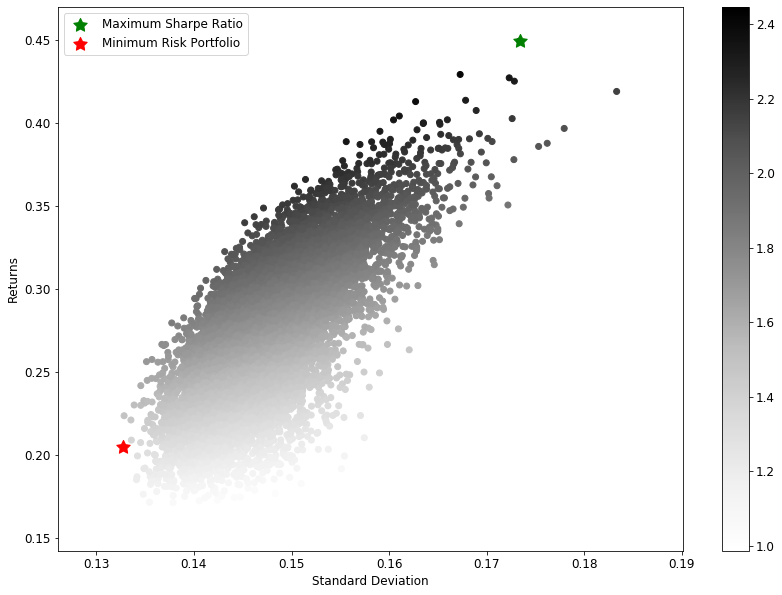

In [556]:
#Highest Sharpe Ratio Point
max_sharpe = results_df.iloc[results_df['sharpe ratio'].idxmax()]
#Minimum Risk Point
min_risk = results_df.iloc[results_df['risk'].idxmin()]

plt.subplots(figsize=(14,10))
plt.scatter(results_df['risk'], results_df['returns'], c = results_df['sharpe ratio'], cmap = 'Greys')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.colorbar()

plt.scatter(max_sharpe[1], max_sharpe[0], marker=(5,1,0),color='green',s = 200, label = 'Maximum Sharpe Ratio')

plt.scatter(min_risk[1], min_risk[0], marker=(5,1,0),color='red',s = 200, label = 'Minimum Risk Portfolio')

plt.legend()

#plt.xlim([0.1,0.6])
#plt.ylim([0.1,0.9])

plt.show()

### Markovitz Optimization

The entire mean portfolio theory optimization math can be found here (healthy individuals are advised not to look):

https://sites.math.washington.edu/~burke/crs/408/fin-proj/mark1.pdf

In [557]:
m = np.array(portfolio_df['yearly returns'])
sigma = selected_stocks_variance_df.loc[portfolio_df['tickers'].unique()][portfolio_df['tickers'].unique()].values
e = np.array(10*[1])
num1 = (np.linalg.inv(sigma)).dot(e)
den1 = (np.transpose(e)).dot(num1)
w_min_var = num1/den1
min_return = (np.transpose(m)).dot(w_min_var)
print('Return for minimum risk was: {:0.2f}%'.format(100*min_return))
_, min_risk_markovitz = get_portfolio_variance(portfolio_df, selected_stocks_variance_df, w_min_var)
print('Minimum risk was: {:0.2f}%'.format(100*min_risk_markovitz))

num2 = (np.linalg.inv(sigma)).dot(m)
den2 = (np.transpose(e)).dot(num2)
w_market = num2/den2

v = w_market - w_min_var

desired_return = 0.3 #Input the percentage return desired

alpha = (desired_return - (np.transpose(m)).dot(w_min_var)) / (np.transpose(m)).dot(v)

w_final = w_min_var + alpha*v
test_return = (np.transpose(m)).dot(w_final)

if (min(w_final) < -0.1) | (max(w_final) > 1):
    print('\nWarning: Weights may not have optimized correctly as one KKT condition can\'t be met.')
    print('weights: {}'.format(w_final))
else:
    print('\nDesired Return was: {:0.2f}%'.format(100*desired_return))
    _, desired_risk = get_portfolio_variance(portfolio_df, selected_stocks_variance_df, w_final)
    print('Risk for desired return was: {:0.2f}%'.format(100*desired_risk))
    print('\n\nw_min_var = {}\n\nw_desired_return = {}'.format(w_min_var, w_final))


Return for minimum risk was: 17.65%
Minimum risk was: 12.72%

Desired Return was: 30.00%
Risk for desired return was: 13.42%


w_min_var = [ 0.10184701  0.05785603  0.01083448  0.00619424  0.15100358  0.45853679
  0.23691724 -0.04793721  0.01951037  0.00523747]

w_desired_return = [ 0.10499111  0.03230389  0.13221628 -0.08998093  0.17200982  0.38736849
  0.25556217 -0.09260875  0.13515401 -0.03701609]


### Plot everything

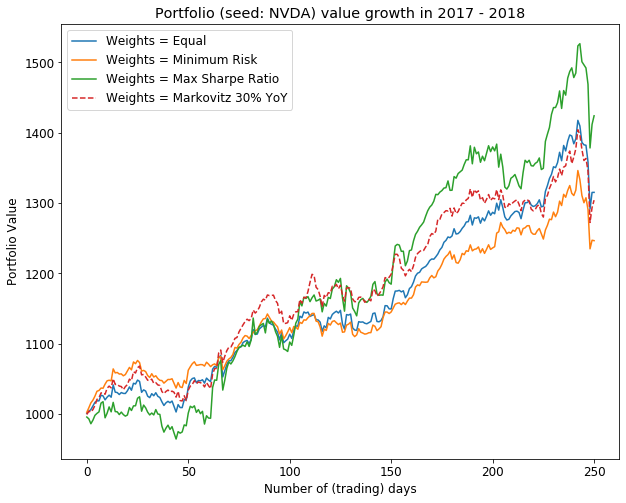

In [558]:
p_standard = future_returns(test_df, similar_stocks, 1000)
p_optimized = future_returns(test_df, similar_stocks, 1000, weights = max_sharpe[3:].tolist())
p_minrisk = future_returns(test_df, similar_stocks, 1000, weights = min_risk[3:].tolist())
p_markovitz = future_returns(test_df, similar_stocks, 1000, weights = list(w_final))

plt.figure(figsize = (10,8))

plt.plot(list(p_standard.values()), label = 'Weights = Equal')
plt.plot(list(p_minrisk.values()), label = 'Weights = Minimum Risk')
plt.plot(list(p_optimized.values()), label = 'Weights = Max Sharpe Ratio')
plt.plot(list(p_markovitz.values()), label = 'Weights = Markovitz 30% YoY', ls = '--')

plt.legend()
plt.xlabel('Number of (trading) days')
plt.ylabel('Portfolio Value')
plt.title('Portfolio (seed: ' + seed_stock + ') value growth in 2017 - 2018')
plt.show()

# Random Tries Below!

In [536]:
seed_stock = 'LRCX'
diverse_stocks, correlations = correlation_minimized_selection_algorithm(selected_stocks, 10, seed_stock)
diverse_stocks

% Variance Explained for LRCX = 0.67
Sum of the correlations is -0.16
Next Most Diverse Stock is OKE
% Variance Explained for OKE = 0.79
Sum of the correlations is -0.04
Next Most Diverse Stock is MYL
% Variance Explained for MYL = 0.67
Sum of the correlations is 0.2
Next Most Diverse Stock is COST
% Variance Explained for COST = 0.68
Sum of the correlations is 0.36
Next Most Diverse Stock is HAL
% Variance Explained for HAL = 0.71
Sum of the correlations is 0.74
Next Most Diverse Stock is PSA
% Variance Explained for PSA = 0.7
Sum of the correlations is 0.4
Next Most Diverse Stock is STX
% Variance Explained for STX = 0.74
Sum of the correlations is 1.0
Next Most Diverse Stock is DLR
% Variance Explained for DLR = 0.67
Sum of the correlations is 0.87
Next Most Diverse Stock is PWR
% Variance Explained for PWR = 0.75
Sum of the correlations is 1.33
Next Most Diverse Stock is AMZN


['LRCX', 'OKE', 'MYL', 'COST', 'HAL', 'PSA', 'STX', 'DLR', 'PWR', 'AMZN']

In [537]:
portfolio_df = high_returns_df
portfolio_df = portfolio_df[portfolio_df['tickers'].isin(diverse_stocks)].reset_index(drop = True)
portfolio_df
#portfolio_df = high_returns_df.sort_values('yearly returns', ascending = False)[0:10]
#diverse_stocks = portfolio_df['tickers'].unique().tolist()

,tickers,yearly returns,yearly variance
0,AMZN,0.402172,0.512282
1,COST,0.124215,0.073343
2,DLR,0.134813,0.234155
3,HAL,0.121877,0.324751
4,LRCX,0.275658,0.175531
5,MYL,0.119864,0.301644
6,OKE,0.231394,0.695754
7,PSA,0.112242,0.175307
8,PWR,0.115408,0.389328
9,STX,0.102433,0.378746


In [538]:
'''
This block gives the portfolio return, risk, and sharpe ratio is all assets in the portfolio have equal weight.
'''
p = get_portfolio_return(portfolio_df)
_,q = get_portfolio_variance(portfolio_df, selected_stocks_variance_df)
s = get_sharpe_ratio(portfolio_df, selected_stocks_variance_df, 2.5)

print('Portfolio Returns: {}%'.format(round(p*100,2)))
print('Portfolio Risk: {}%'.format(round(q*100,2)))
print('Portfolio Sharpe Ratio: {}'.format(round(s,2)))

Portfolio Returns: 17.4%
Portfolio Risk: 16.82%
Portfolio Sharpe Ratio: 0.89


In [539]:
results_df = monte_carlo_portfolios(portfolio_df, selected_stocks_variance_df, 2.5, 5000)

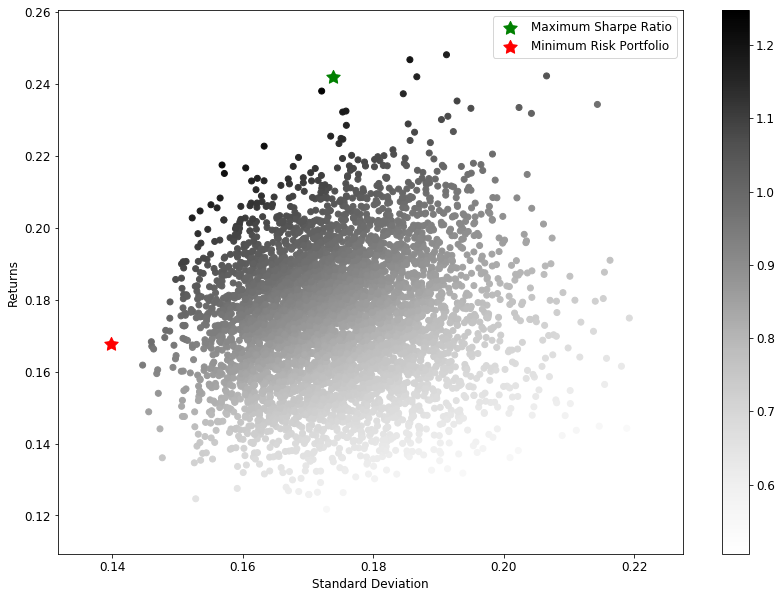

In [540]:
#Highest Sharpe Ratio Point
max_sharpe = results_df.iloc[results_df['sharpe ratio'].idxmax()]
#Minimum Risk Point
min_risk = results_df.iloc[results_df['risk'].idxmin()]

plt.subplots(figsize=(14,10))
plt.scatter(results_df['risk'], results_df['returns'], c = results_df['sharpe ratio'], cmap = 'Greys')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.colorbar()

plt.scatter(max_sharpe[1], max_sharpe[0], marker=(5,1,0),color='green',s = 200, label = 'Maximum Sharpe Ratio')

plt.scatter(min_risk[1], min_risk[0], marker=(5,1,0),color='red',s = 200, label = 'Minimum Risk Portfolio')

plt.legend()

#plt.xlim([0.1,0.6])
#plt.ylim([0.1,0.9])

plt.show()

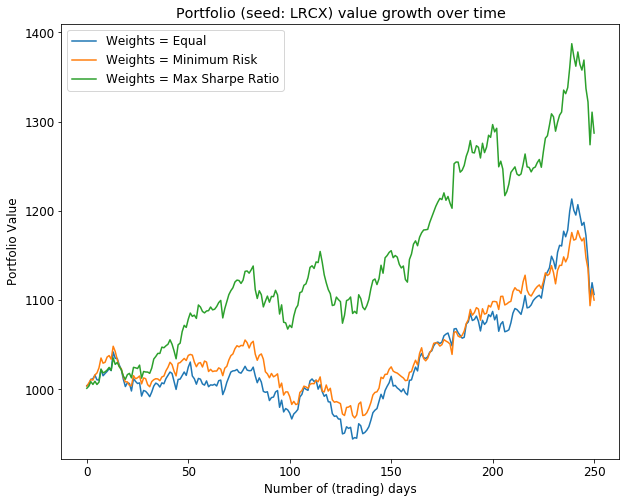

In [541]:
p_standard = future_returns(test_df, diverse_stocks, 1000)
p_optimized = future_returns(test_df, diverse_stocks, 1000, weights = max_sharpe[3:].tolist())
p_minrisk = future_returns(test_df, diverse_stocks, 1000, weights = min_risk[3:].tolist())

plt.figure(figsize = (10,8))

plt.plot(list(p_standard.values()), label = 'Weights = Equal')
plt.plot(list(p_minrisk.values()), label = 'Weights = Minimum Risk')
plt.plot(list(p_optimized.values()), label = 'Weights = Max Sharpe Ratio')

plt.legend()
plt.xlabel('Number of (trading) days')
plt.ylabel('Portfolio Value')
plt.title('Portfolio (seed: ' + seed_stock + ') value growth over time')
plt.show()